## Data loading

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# First glimpse of all the available movies in the dataset

column_movies = ["film_id", "movie_id", "title", "release_date", "gross_revenue", "duration_min", "language", "country", "categories"]

movies_df = pd.read_csv('./Data/MovieSummaries/movie.metadata.tsv', sep='\t', header=None, names=column_movies)
movies_df.head()

,film_id,movie_id,title,release_date,gross_revenue,duration_min,language,country,categories
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [4]:
# Dataframe of all the characters in the movies

column_characters = ["film_id", "movie_id", "release_date", "character", "born_date", "gender", "height", "ethnicity", "actor_name", "actor_age_at_movie_release", "actor_map_ID","character_ID","actor_ID"]

character_df = pd.read_csv('./Data/MovieSummaries/character.metadata.tsv', sep='\t', header=None, names = column_characters)
character_df.sample(10)

,film_id,movie_id,release_date,character,born_date,gender,height,ethnicity,actor_name,actor_age_at_movie_release,actor_map_ID,character_ID,actor_ID
356787,61182,/m/0glt1,1929-02-01,NaN,1940-12-30,M,NaN,NaN,James Burrows,-11.0,/m/0cgnwq1,NaN,/m/06j0md
194961,13706801,/m/03cfq4q,2006-10,NaN,NaN,NaN,NaN,NaN,Bill Erfurth,NaN,/m/0gchmyf,NaN,/m/0gc3_tk
309524,19286365,/m/04ld7vr,NaN,NaN,1917-01-17,M,NaN,/m/0bhsnb,M. G. Ramachandran,NaN,/m/04lr5ss,NaN,/m/02dk8v
45487,15343180,/m/03m5n8y,1990,NaN,NaN,NaN,NaN,NaN,Dipak Alegaokar,NaN,/m/0gdk4gq,NaN,/m/0gdk4gs
116426,23829273,/m/06_w90f,2010-10-31,Darryl,1967-12-13,M,1.78,/m/0x67,Jamie Foxx,42.0,/m/07y8vs_,/m/0fd366s,/m/01wmxfs
37565,7567194,/m/0265jt4,1991,NaN,NaN,F,NaN,NaN,Jaswinder Jassi,NaN,/m/0jn79r3,NaN,/m/0jn79r6
301656,11330813,/m/02r7zn7,2005-09-11,NaN,1961-12-26,M,NaN,NaN,John Lynch,43.0,/m/04htv03,NaN,/m/074s4p
79914,10843767,/m/04j0njj,2006-02-15,Jean-François,1964-01-11,M,NaN,NaN,Albert Dupontel,42.0,/m/02wtfpw,/m/02wtfpz,/m/0701sj
6236,4825726,/m/0cpt3n,2005-08-12,NaN,NaN,NaN,NaN,NaN,Catalina Aristizábal,NaN,/m/0gc9_7d,NaN,/m/0gc3y6k
364718,30708894,/m/0g9vp4t,NaN,NaN,1906-09-16,M,NaN,NaN,Jacques B. Brunius,NaN,/m/0jx7l2w,NaN,/m/04f14x9


In [5]:
# List of different actors 
actors = character_df['actor_name'].unique()

# Number of actors per movie  
films = character_df.groupby('movie_id').actor_name.count()

# Number of characters per movie 
char = character_df.groupby('movie_id').character.count()

We may look at the frequency of different actors (nb of movies/year), look at the histogram of number of times each actor played (distrib), look at when the age started (distrib), ...

## 1. Frequency of presence in movies per year 

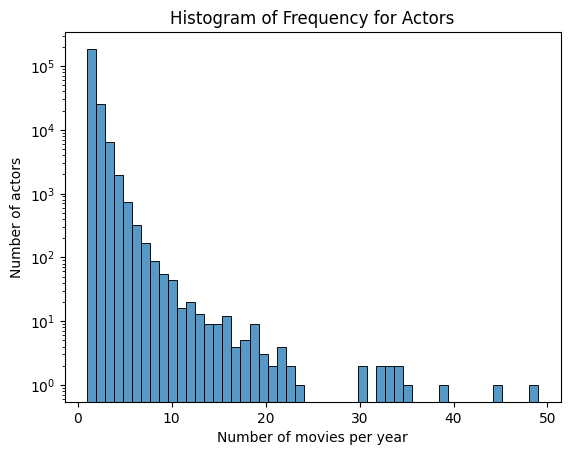

In [6]:
character_df['release_date'] = pd.to_datetime(character_df['release_date'], errors='coerce')

frequency_df = character_df.groupby(['actor_name', character_df['release_date'].dt.year]).size().reset_index(name='movie_count')
sns.histplot(frequency_df['movie_count'], bins = 50, log = True)
plt.ylabel("Number of actors")
plt.xlabel("Number of movies per year")
plt.title('Histogram of Frequency for Actors')
plt.show()

Possible limitations of the graph : outliers (we may look at who they are) and does a huge frquency over one year is better than a constant lower frequency ?  

In [7]:
frequency_max = frequency_df.sort_values(by='movie_count', ascending=False)
top5_frequency = frequency_max.head(5)
print(top5_frequency)

             actor_name  release_date  movie_count
180202  Roscoe Arbuckle        1914.0           49
156501     Oliver Hardy        1916.0           45
76332      Harold Lloyd        1919.0           39
180201  Roscoe Arbuckle        1913.0           35
32608   Charlie Chaplin        1914.0           34


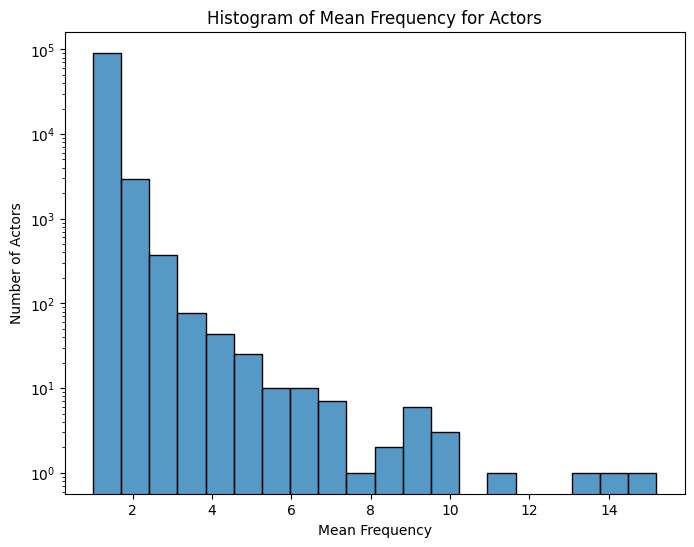

In [8]:
mean_frequency = frequency_df.groupby('actor_name')['movie_count'].mean().reset_index(name='mean_frequency')

plt.figure(figsize=(8, 6))
sns.histplot(mean_frequency['mean_frequency'], bins=20,log = True, kde=False)
plt.xlabel('Mean Frequency')
plt.ylabel('Number of Actors')
plt.title('Histogram of Mean Frequency for Actors')
plt.show()

In [9]:
top5_actors_mf = mean_frequency.nlargest(5, 'mean_frequency')
print(top5_actors_mf)

             actor_name  mean_frequency
14425  Charlotte Burton            15.2
54785     Louise Lester            14.0
37143        Jack Davis            13.5
90908       Vivian Rich            11.2
13107    Caroline Cooke            10.0


When we search for all these actors, we can see that they are all from the beginning of the movie industry (1910s, early 1920s) when the movies were quite short and silent, so the artistic approach was way more simplified as today. In fact, Roscoe Arbuckle worked as the same time as an actor, a screenwriter and a producer. 

By highlighting that, we could assess that taking into account the period at which the movies were produced is critical. 

So, we tried to filter by period : 

In [10]:
average_movie_count_per_year = frequency_df.groupby('release_date')['movie_count'].agg(['mean', 'std']).reset_index()
average_movie_count_per_year.columns = ['release_date', 'average_movies', 'std_dev']
average_movie_count_per_year.head(13)

,release_date,average_movies,std_dev
0,1894.0,1.000,NaN
1,1895.0,1.000,NaN
2,1896.0,1.000,0.000000
3,1897.0,1.000,NaN
4,1900.0,1.000,0.000000
5,1901.0,1.000,NaN
6,1902.0,1.000,0.000000
7,1903.0,1.000,0.000000
8,1904.0,1.000,NaN
9,1905.0,1.000,0.000000


We can filter all the years before 1908 which seems not very insightful, and then plot the average frequency per year with the standard deviation : 

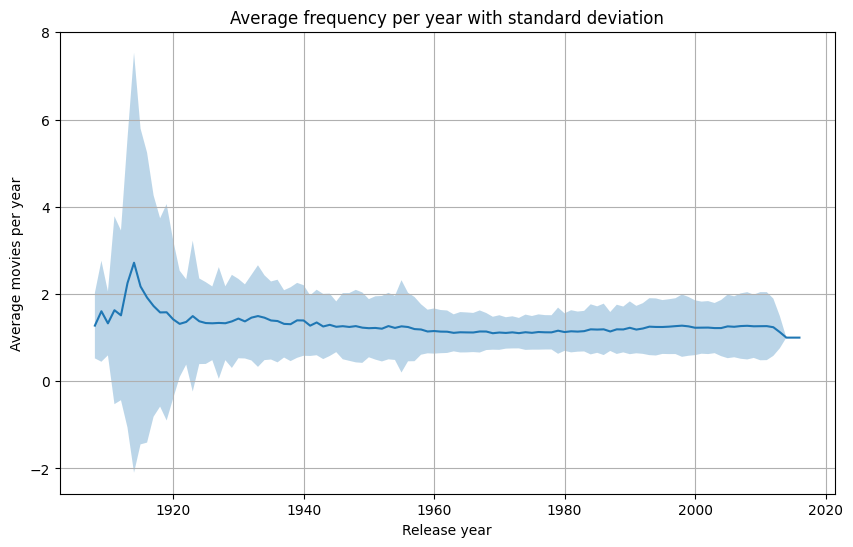

In [11]:
average_movie_count_per_year = average_movie_count_per_year[average_movie_count_per_year['release_date'] >= 1908]

plt.figure(figsize=(10, 6))
sns.lineplot(data=average_movie_count_per_year, x='release_date', y='average_movies')
plt.fill_between(average_movie_count_per_year['release_date'], 
                 average_movie_count_per_year['average_movies'] - average_movie_count_per_year['std_dev'],
                 average_movie_count_per_year['average_movies'] + average_movie_count_per_year['std_dev'],
                 alpha=0.3)
plt.xlabel('Release year')
plt.ylabel('Average movies per year')
plt.title('Average frequency per year with standard deviation')
plt.grid(True)
plt.show()

## 2. Career span of actors

Mean career span for male actors: 13.08 years (+/-  11.21) 
Mean career span for female actors: 11.38 years (+/- 10.74) 


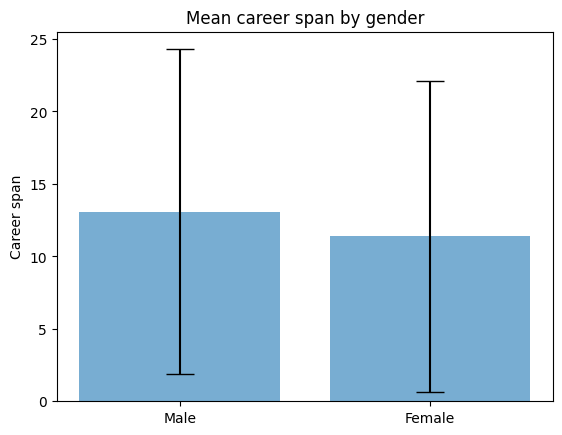

In [19]:
character_df['release_date'] = pd.to_datetime(character_df['release_date'], errors='coerce')

actor_span = character_df.groupby('actor_name')['release_date'].agg(['min', 'max']).reset_index()
actor_span['career_span'] = (actor_span['max'] - actor_span['min']).dt.days / 365

# Avoid anomalies due to missing values (NaT)
span_thresh = 50 
actor_span = actor_span[(actor_span['career_span'] != 0) & (actor_span['career_span'] < span_thresh)]
actor_career_span = actor_span.merge(character_df[['actor_name', 'gender']], on='actor_name', how='inner')
actor_career_span = actor_career_span.drop_duplicates(subset=['actor_name', 'career_span', 'gender'])

male_actors = actor_career_span[actor_career_span['gender'] == 'M']
female_actors = actor_career_span[actor_career_span['gender'] == 'F']

# Calculate mean career span for male and female actors and std and plot with confidence intervals
mean_career_span_male = male_actors['career_span'].mean()
std_career_span_male = male_actors['career_span'].std()
mean_career_span_female = female_actors['career_span'].mean()
std_career_span_female = female_actors['career_span'].std()

print(f"Mean career span for male actors: {mean_career_span_male:.2f} years (+/-  {std_career_span_male:.2f}) ")
print(f"Mean career span for female actors: {mean_career_span_female:.2f} years (+/- {std_career_span_female:.2f}) ")

labels = ['Male', 'Female']
x_pos = range(len(labels))
plt.bar(x_pos, [mean_career_span_male, mean_career_span_female], yerr=[std_career_span_male, std_career_span_female], align='center', alpha=0.6, ecolor='black', capsize=10)
plt.xticks(x_pos, labels)
plt.ylabel('Career span')
plt.title('Mean career span by gender')

plt.show()

This is a relatively high variance, so we can not assess anything about the career span of male or female yet. Let's try to do a t-test : 

In [13]:
from scipy.stats import ttest_ind

t_statistic, p_value = ttest_ind(male_actors['career_span'], female_actors['career_span'])

print(f"t-statistic: {t_statistic:.2f}, p-value: {p_value:.4f}")

t-statistic: 13.15, p-value: 0.0000


We can assess that there is strong evidence about the difference between male and female actors. 

## 3. Number of movies per actor

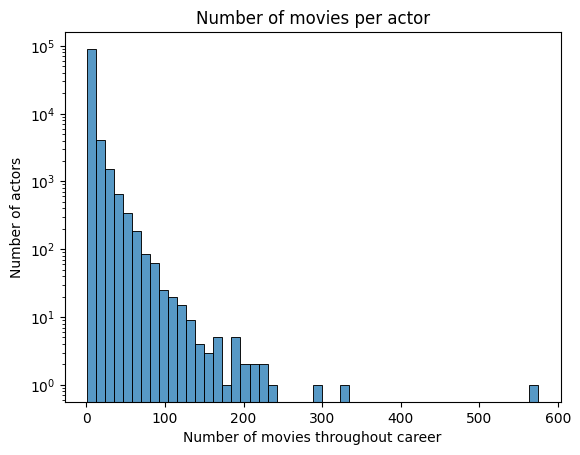

In [14]:
actor_nb_movie = character_df.groupby(['actor_name', 'gender', 'movie_id']).size().reset_index(name='appearance_count')
actor_nb_movie = actor_nb_movie.groupby(['actor_name', 'gender']).size().reset_index(name='total_movie_count')

sns.histplot(actor_nb_movie, x='total_movie_count', bins=50, log=True)
plt.ylabel("Number of actors")
plt.xlabel("Number of movies throughout career")
plt.title("Number of movies per actor")
plt.show()

In [15]:
sorted_actors = actor_nb_movie.sort_values(by='total_movie_count', ascending=False) 
top_5_actors_corrected = sorted_actors.head(5)
print(top_5_actors_corrected)

               actor_name gender  total_movie_count
62041           Mel Blanc      M                575
64910  Mithun Chakraborty      M                328
69057        Oliver Hardy      M                299
65110            Mohanlal      M                234
57406           Mammootty      M                225


The top 5 is mainly composed of mens, let's try to compare with women. In fact, we may have to consider productions locally and by period too, because the leaderboard is exclusively from America in the early ages of cinema and from India nowadays for example.

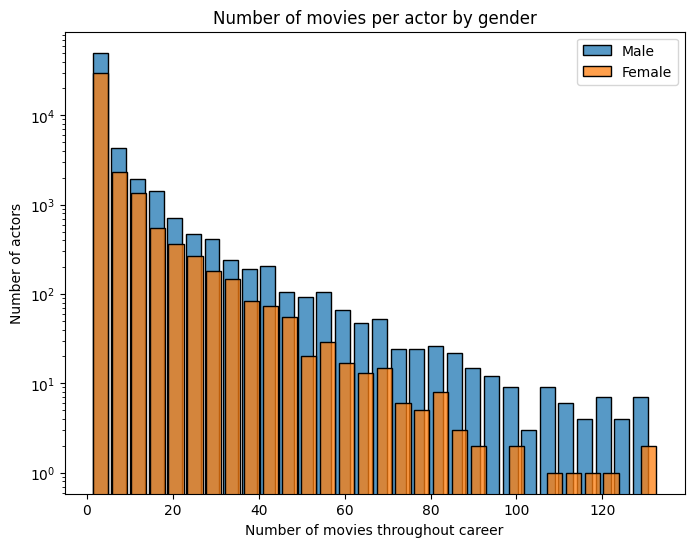

In [16]:
male_data = actor_nb_movie[actor_nb_movie['gender'] == 'M']
female_data = actor_nb_movie[actor_nb_movie['gender'] == 'F']

# The max number of movies for women are 133 so we filter values above to compare
male_filtered = male_data[male_data['total_movie_count'] <= 133]
female_filtered = female_data[female_data['total_movie_count'] <= 133]

# Plotting separate histograms for men and women with filtered data
plt.figure(figsize=(8, 6))
sns.histplot(male_filtered['total_movie_count'], bins=30, label='Male', log=True, multiple="dodge", shrink=.8)
sns.histplot(female_filtered['total_movie_count'], bins=30, label='Female', log=True, multiple="dodge", shrink=.8)

plt.ylabel("Number of actors")
plt.xlabel("Number of movies throughout career")
plt.title("Number of movies per actor by gender")
plt.legend()
plt.show()

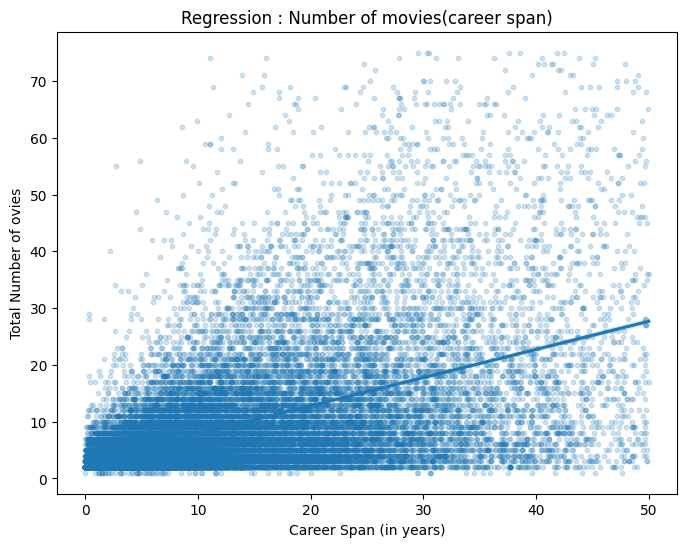

In [18]:
merged_data = pd.merge(actor_span, actor_nb_movie, on='actor_name', how='inner')

# Remove outliers for better visualization
thresh = 75
merged_data = merged_data[merged_data['total_movie_count'] <=  thresh]

# Perform a regression
plt.figure(figsize=(8, 6))
sns.regplot(x='career_span', y='total_movie_count', data=merged_data, scatter_kws={"s": 10, "alpha": 0.2})
plt.xlabel("Career Span (in years)")
plt.ylabel("Total Number of ovies")
plt.title("Regression : Number of movies(career span)")
plt.show()

## 4. Combining all three factors

              actor_name  movies_per_actor  career_span  mean_frequency
0       Cesarine Prinz\t               2.0     4.238356             1.0
2   'Big Bill' Giddinger               1.0     8.438356             1.0
25  A. Edward Sutherland               1.0    14.378082             2.0
36           A. Kanayeva               1.0    11.150685             1.0
45            A. Smirnov               1.0     6.728767             1.0


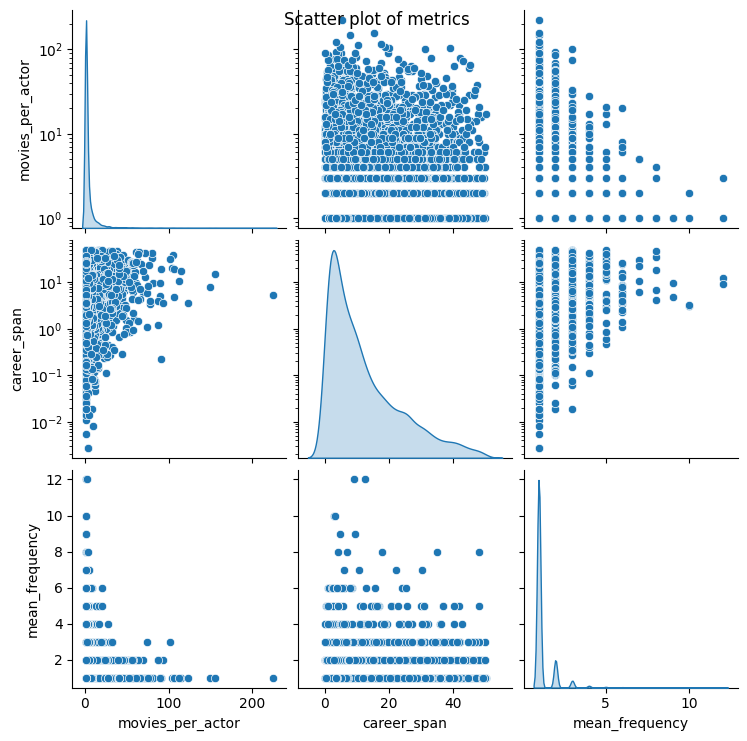

In [24]:
print(actor_metrics.head())
g = sns.pairplot(actor_metrics, diag_kind='kde')

for i in range(g.axes.shape[0] - 1):
    for j in range(g.axes.shape[1] - 1):
        ax = g.axes[i, j]
        if i == j:
            ax.set_yscale('log')

plt.suptitle('Scatter plot of metrics')
plt.show()